In [2]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
import pickle
from sklearn.cluster import DBSCAN
from sklearn.metrics import mutual_info_score

import matplotlib.pyplot as plt
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [3]:
def plot_freq(gap_freq, left_context_freq, right_context_freq, timestamp, relative_position, count = 20):
    
    fig2, ax = plt.subplots(nrows=1, ncols=1,figsize=(30, 7))
    ax.scatter( np.arange(relative_position.shape[0])+1, relative_position, c="red",marker="D", label = "relative position with respect to timestamp")
    ax.set_title("Time scale invariant Plot of timestamp with relative position")
    ax.set_xlabel("Position with respect to time")
    ax.set_ylabel("relative position ")
    ax.set_xticklabels(timestamp)
    plt.ylim(0, 1)
    ax.legend()
    
    
    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(30, 10))
        
    axs[0].barh( left_context_freq.index[:count][::-1], left_context_freq.values[:count][::-1])
    axs[0].set_title(" frequency plot of top 100 words in left context")
    axs[0].set_xlabel("frequency")
    axs[0].set_ylabel("unique words in left context ")
    
    axs[1].barh( gap_freq.index[:count][::-1], gap_freq.values[:count][::-1])
    axs[1].set_title(" frequency plot of top 100 words in gap")
    axs[1].set_xlabel("frequency")
    axs[1].set_ylabel("unique words in gap ")
    
    axs[2].barh( right_context_freq.index[:count][::-1], right_context_freq.values[:count][::-1])
    axs[2].set_title(" frequency plot of top 100 words in right context")
    axs[2].set_xlabel("frequency")
    axs[2].set_ylabel("unique words in right context ")
#     axs[3].set_xscale("log")
#     axs[3].set_yscale("log")


    return fig
# _= plot_freq(edited_tokens_freq_per_group.loc[1], 
#             left_context_freq_per_group.loc[1], 
#             right_context_freq_per_group.loc[1],
#             change_grouped_by_tokens["timestamp"].get_group(2).values,
#             change_grouped_by_tokens["relative_position"].get_group(2).values
#             )

def display_article_content(index, change_html_series, edited_tokens_freq_per_group, left_context_freq_per_group, right_context_freq_per_group, change_grouped_by_tokens, out):
    with out:
        out.clear_output()
        
    if index in change_html_series.index:
        change_html = change_html_series.loc[index]
    else:
        change_html = "<p>empty table according to cleanup</p>"
    
    if index in left_context_freq_per_group.index:
        left_context_freq = left_context_freq_per_group.loc[index]
    else:
        left_context_freq = pd.Series()
    
    if index in right_context_freq_per_group.index:
        right_context_freq = right_context_freq_per_group.loc[index]
    else:
        right_context_freq = pd.Series()
        
    if index in edited_tokens_freq_per_group.index:
        edited_tokens_freq = edited_tokens_freq_per_group.loc[index]
    else:
        edited_tokens_freq = pd.Series()
    _ = plot_freq(edited_tokens_freq, left_context_freq, right_context_freq,
            change_grouped_by_tokens["timestamp"].get_group(index).values,
            change_grouped_by_tokens["relative_position"].get_group(index).values)
    with out:
        
#         display(change_html)
        display(f"Word length distribution plot for cluster with {index}")
#         display(fig)
        display(HTML(change_html))

def rank_clusters(change_dataframe, cluster_by):

    rank_by_size = change_dataframe.groupby(cluster_by).size().sort_values(ascending=False)

    rank_by_uniq_editor = change_dataframe.reset_index().groupby(cluster_by)["editor"].nunique().sort_values(ascending=False)

    rank_by_period = change_dataframe.reset_index().groupby(cluster_by)["timestamp"].apply(lambda x: x.max() - x.min()).sort_values(ascending=False)

    rank_by_rate = change_dataframe.reset_index().groupby(cluster_by)["timegap"].apply(lambda x: x.mean()).sort_values(ascending=False)

#     rank_by_uniq_gaptoken = edited_tokens_freq_per_group.groupby(level=0).apply(lambda x: len(x)).sort_values(ascending=False)
    return (rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate)

def get_cluster_wordfreq(change_dataframe, cluster_by, vocab_set):
    
    edited_tokens_freq_per_group = change_dataframe.set_index(cluster_by)["edited_tokens"].apply(lambda tokens: tuple(token for token in tokens if token in vocab_set)).groupby(cluster_by).apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))
    left_context_freq_per_group = change_dataframe.set_index(cluster_by)["left_token"].apply(lambda tokens: tuple(token for token in tokens if token in vocab_set)).groupby(cluster_by).apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))
    right_context_freq_per_group = change_dataframe.set_index(cluster_by)["right_token"].apply(lambda tokens: tuple(token for token in tokens if token in vocab_set)).groupby(cluster_by).apply(lambda x:  pd.Series(np.concatenate(x.values, axis=0)).value_counts(ascending=False))
    
    return (edited_tokens_freq_per_group, left_context_freq_per_group, right_context_freq_per_group)

def create_cluster_html_cleaned(change_dataframe, groupby):
    

    
    zero_gap_mask = ((change_dataframe["ins_string"].str.len() + change_dataframe["del_string"].str.len()) == 0).values

    change_dataframe = change_dataframe.reset_index().set_index(["from revision id","to revision id","timestamp", "editor", "level_5"])
    html_series =  change_dataframe.loc[~zero_gap_mask,:].groupby(cluster_by)[["left_cleaned", "del_cleaned", "ins_cleaned", "right_cleaned"]].apply(lambda x: x.style.render())
    change_dataframe = change_dataframe.reset_index().set_index(["from revision id", "editor", "level_5"])
    return html_series

def create_cluster_html(change_dataframe, groupby):
    
    
    zero_gap_mask = ((change_dataframe["ins_string"].str.len() + change_dataframe["del_string"].str.len()) == 0).values

    change_dataframe = change_dataframe.reset_index().set_index(["from revision id","to revision id","timestamp", "editor", "level_5"])
    html_series =  change_dataframe.loc[~zero_gap_mask,:].groupby(cluster_by)[["left_string", "del_string", "ins_string", "right_string"]].apply(lambda x: x.style.render())
    change_dataframe = change_dataframe.reset_index().set_index(["from revision id", "editor", "level_5"])
    
    return html_series    

## Reading the change object and clustering.

In [102]:
#article_name = "Violence_against_Muslims_in_India"
#article_name = "Yugoslavia"
#article_name = 'Truth'
#article_name = 'Berlin_Wall'
article_name = 'John_Logie_Baird'
change_object_dir =  "../data/change objects/"

change_object_file_name = f"{article_name}_vec.npz"
filename =  f"{article_name}_change.h5"

change_object_file = os.path.join(change_object_dir, filename)


change_vector_dir = "../data/change_vector_optimised/"
change_vec_filename = f"{article_name}_comp_vec.npz"
change_vector_file = os.path.join(change_vector_dir, change_vec_filename)

content_dir = "../data/content/"
len_file = article_name + "_rev_len.h5"
len_file_path = os.path.join(content_dir, len_file)


In [6]:
with open("../../wordvectors/vocabs.pkl", "rb") as file:
    vocabs = pickle.load(file)
with open("../../wordvectors/filtered_vocabs.pkl", "rb") as file:
    filtered_vocabs = pickle.load(file)
vocabs_set = set(vocabs)
filtered_vocabs_set = set(filtered_vocabs)

In [103]:
%%time
if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")
    
change_object_dataframe["edited_tokens"] = change_object_dataframe["ins_tokens"]  + change_object_dataframe["del_tokens"]
rev_len_df = pd.read_hdf(len_file_path, key = "rev_len")

with open(change_vector_file, "rb") as file:
    arrays_dict = np.load(file)
    clean_weighted_4 = arrays_dict["4_clean_weighted"]
#     clean_not_weighted_4 = arrays_dict["4_clean_not_weighted"]
#     notclean_weighted_4 = arrays_dict["4_notclean_weighted"]
#     notclean_not_weighted_4 = arrays_dict["4_notclean_not_weighted"]
    clean_weighted_10 = arrays_dict["10_clean_weighted"]
#     clean_not_weighted_10 = arrays_dict["10_clean_not_weighted"]
#     notclean_weighted_10 = arrays_dict["10_notclean_weighted"]
#     notclean_not_weighted_10 = arrays_dict["10_notclean_not_weighted"]

CPU times: user 504 ms, sys: 836 ms, total: 1.34 s
Wall time: 1.35 s


### Make left, ins and delete string for visualisation

In [104]:
change_object_dataframe["left_string"] = change_object_dataframe["left_token"].str.join(" ")
change_object_dataframe["ins_string"] = change_object_dataframe["ins_tokens"].str.join(" ")
change_object_dataframe["del_string"] = change_object_dataframe["del_tokens"].str.join(" ")
change_object_dataframe["right_string"] = change_object_dataframe["right_token"].str.join(" ")

change_object_dataframe["left_cleaned"] = change_object_dataframe["left_token"].apply(lambda tokens: tuple(token for token in tokens if token.isalnum())).str.join(" ")
change_object_dataframe["del_cleaned"] = change_object_dataframe["ins_tokens"].apply(lambda tokens: tuple(token for token in tokens if token.isalnum())).str.join(" ")
change_object_dataframe["ins_cleaned"] = change_object_dataframe["del_tokens"].apply(lambda tokens: tuple(token for token in tokens if token.isalnum())).str.join(" ")
change_object_dataframe["right_cleaned"] = change_object_dataframe["right_token"].apply(lambda tokens: tuple(token for token in tokens if token.isalnum())).str.join(" ")



## Finding relative positions of change object

In [105]:
change_object_dataframe = change_object_dataframe.reset_index().set_index('from revision id')
change_object_dataframe = change_object_dataframe.join(rev_len_df.set_index("rev_id"))
change_object_dataframe.index.name = "from revision id"

change_object_dataframe["relative_position"] =(change_object_dataframe["left_neigh"]+1)/(change_object_dataframe["length"])

change_object_dataframe = change_object_dataframe.reset_index().set_index(["from revision id","timestamp", "level_5"])




## CLustering, Ranking and Visualisation of Different weighting of neighbourhood context vectors.

Each change object consists of gap, right context and left context. 

To cluster similar words together each change object needs to be converted to a vector of fixed dimension. 
We utilised Word vectors embeddings of 300 dimension to convert change object to change vectors. Each of left and right context is seperately averaged using word embeddings and then concatinated along vector dimension to convert change object as vector of 600 dimension.

Vocabulary: Is one million vocabulary from fast text embedding word vectors sorted by their frequency of occurrency in the corpus.

**Cleaned** Vocabulary: Is created after cleaning the vocabulary where its top 20 ranked keywords are removed and all the word of size less than 4 is removed.

We utlise these two vocabulary and its corresponding vector to average context words and create change vectors. Each word in the context is weighted according to its proximity from gap. Using different weighing mechanism we create 8 word vectors.


Following is the description of each of them:-
1. clean_weighted_4: Taking four nearby neighbours and intersecting with **Cleaned** vocaboulary. Vectors corresponding to   these context words were averaged after weighting them with inverse of words distance from gap. 
2. clean_not_weighted_4: Taking four nearby tokens of context and intersecting with **Cleaned** vocabulary.Vectors corresponding to   these context words were averaged without any weighting.
3. notclean_weighted_4:   Taking four nearby neighbours and intersecting with vocaboulary. Vectors corresponding to   these context words were averaged after weighting them with inverse of words distance from gap. 
4. notclean_not_weighted_4:  Taking four nearby tokens of context and intersecting with vocabulary.Vectors corresponding to   these context words were averaged without any weighting. 
5. clean_weighted_10: Taking ten nearby neighbours and intersecting with **Cleaned** vocaboulary. Vectors corresponding to   these context words were averaged after weighting them with inverse of words distance from gap.
6. clean_not_weighted_10: Taking ten nearby tokens of context and intersecting with **Cleaned** vocabulary.Vectors corresponding to   these context words were averaged without any weighting.
7. notclean_weighted_10: Taking ten nearby neighbours and intersecting with vocaboulary. Vectors corresponding to   these context words were averaged after weighting them with inverse of words distance from gap.
8. notclean_not_weighted_10: Taking ten nearby tokens of context and intersecting with vocabulary.Vectors corresponding to   these context words were averaged without any weighting.




---
#### Ranking
###### Clustered groups were then ranked on following parameters.

1.  Size of clusters(rank_by_size): This parameter sorts clusters by total number of data points contained in the cluster.
2. No of unique editors is clusters(rank_by_uniq_editor): This prameter sorts cluster by number of unique editors involved in the cluster.
3. Total period of cluster(rank_by_period): This sorts clusters based on the period  for which cluster was edited. which is the difference between edit timestamp of first cluster and edit timestamp of last cluster.
4. Average edit rate of cluster(rank_by_period): Rate is timegap between two edits. This sorts cluster which has higest mean edit rates to lowest mean edit rates

widgets.interact has a __**index=**__ parameter which can alter rankingg of clusters following 4 are the name of ranking parameter corresponding to following 4 given above please change them accordingly. It takes a variable named clean_weighted_4_drop_downs which can alter the ranking basis to use different ranking methods use different index of variable. Following list entails which parameter to use for which ranking

1. rank_by_size: clean_weighted_4_drop_downs[0] 
2. rank_by_uniq_editor: clean_weighted_4_drop_downs[1]
3. rank_by_period: clean_weighted_4_drop_downs[2]
4. rank_by_rate: clean_weighted_4_drop_downs[3]



---
#### clustering

##### DBSCAN clustering 

DBSCAN is a clustering method which do not have a fixed amount of clusters. DBSCAN starts with  core points which has minimu number of samples within epsilon distance then it uses epsilon distance to add new points to the clusters. It has has two main parameters minimum number of samples in a cluster and epsilon distance. Both of them control the growth of the clusters. A bigger number of minimum samples will tend to have few clusters as it will be harder to form a cluster with core samples. A smaller epsilon distance will stop addition of new points to core group thus leading to more clusters.



Sickit Learns implementation has two parameters eps and min_samples. which corresponds to the minmum distance between two neighbourhood points to be considered in the same neighbourhood. As eps values will start to to increase more points will start getting added in a cluster thus forming bigger clusters.
eps: epsilon 
min_samples: controls the minimum number of points in cluster.


dbscan_params has five config stored as can be seen below 0 th is default. -1 gives biggeer and fewer cluster

---
---
#### Visulaisation

We have two kinds of plots first is three frequency plots tokens, namely in gap, left frequency and right frequency another is time invariant plot of relative position of change object with respect to its relative occurrence.

As we have two kinds of change object vectors one where vocabulary is cleaned another is un cleaned one. We can have two kinds of frequency two one which only plots cleaned token frequency and another which plots uncleaned token frequency. Function get_cluster_wordfreq(
    cluster_df, cluster_by, vocabs_set) has three parameter first one is cluster, second one is parameter on which clustering is done last one is vocab set to be considered for frequency. If this vocab set is changed to filtered_vocabs_set only filtered words frequency will be shown.
    
 __CLuster strings:-__ Apart from this we also show all the elements of clusters down. As these change objects are dervied directly from wiki who they are by default not cleaned but we provide two functions one which shows clusters gap and context without removal of any special characters. Second method removes all the wikiwho tokens which is not alphanumeric to increase readability.
 Two methods are 
 1.create_cluster_html(non_neg_cluster_df, cluster_by)
 2.create_cluster_html_cleaned(non_neg_cluster_df, cluster_by)
 
 Both have similar function signature first is default used when change vectors are cleaned second one is used when change vector is not cleaned. But as removal of non alphanumeric has not significance for change vector cleaning. All cluster viewing can be replaced to 


### clean_weighted_4





In [106]:
## these are the suggested parameters first one gives quite good results last one gives few clusters.
dbscan_params =[
    { "eps": 1.5, "min_samples": 5 },
    { "eps": 1, "min_samples": 5 }, 
    { "eps": 1.25, "min_samples": 5 },
    { "eps": .75, "min_samples": 5 },  
    { "eps": .1, "min_samples": 7 },
    { "eps": .001, "min_samples": 10 }]

In [107]:
%%time 

params = dbscan_params[0]
cluster_by = "clean_weighted_4"
parmstr = '_'.join(str(x) for x in dbscan_params[0].values())

try:
    change_object_dataframe[cluster_by] = pd.read_pickle(f'../data/cluster_cache/{article_name}-{cluster_by}-{parmstr}.p')
except:
    clusters = DBSCAN(**params).fit(clean_weighted_10)
    change_object_dataframe[cluster_by] = pd.Series(clusters.labels_, index= change_object_dataframe.index)
    change_object_dataframe[cluster_by].to_pickle(f'../data/cluster_cache/{article_name}-{cluster_by}-{parmstr}.p')
    

non_zero_cluster_mask = (change_object_dataframe[cluster_by] != -1)

non_neg_cluster_df = change_object_dataframe.loc[non_zero_cluster_mask, :]

rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate = rank_clusters(non_neg_cluster_df, cluster_by)

#uncomment the next line and comment the line afer that if you want to see frequency of words without cleaning up
# clean_weighted_4_gap_freq, clean_weighted_4_left_context_freq, clean_weighted_4_right_context_freq = get_cluster_wordfreq(non_neg_cluster_df, cluster_by, vocabs_set)
clean_weighted_4_gap_freq, clean_weighted_4_left_context_freq, clean_weighted_4_right_context_freq = get_cluster_wordfreq(
    non_neg_cluster_df, cluster_by, filtered_vocabs_set)

clean_weighted_4_grouped = non_neg_cluster_df.reset_index().groupby(cluster_by)

clean_weighted_4_repers = create_cluster_html_cleaned(non_neg_cluster_df, cluster_by)

clean_weighted_4_drop_downs = [list(zip(np.arange(rank_by_size.size), rank_by_size.index)), 
                list(zip(np.arange(rank_by_uniq_editor.size), rank_by_uniq_editor.index)),
                list(zip(np.arange(rank_by_period.size), rank_by_period.index)),
                list(zip(np.arange(rank_by_rate.size), rank_by_rate.index))]

CPU times: user 2.25 s, sys: 0 ns, total: 2.25 s
Wall time: 2.26 s


outliers: 3097 out of 4900
clusters: 172


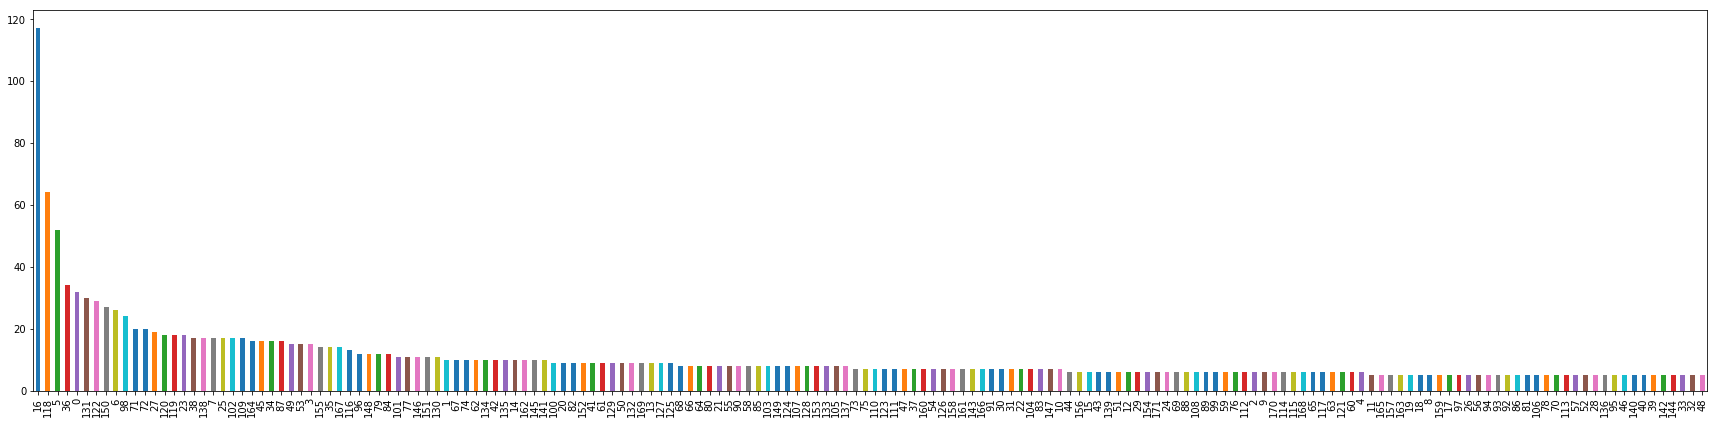

In [108]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")
print(f"clusters: {len(non_neg_cluster_df[cluster_by].unique())}")

non_neg_cluster_df[cluster_by].value_counts().plot( figsize=(30, 7), kind='bar') #.hist(figsize=(30, 7), bins=len(set(non_neg_cluster_df[cluster_by])))

In [109]:
out_clean_weighted_4 = widgets.Output(layout={'r': '1px solid black'})
caption = widgets.Label(value='Choose parameters:')

_=widgets.interact(display_article_content, index=clean_weighted_4_drop_downs[0], 
                   change_html_series= widgets.fixed(clean_weighted_4_repers),
                   edited_tokens_freq_per_group= widgets.fixed(clean_weighted_4_gap_freq), 
                   left_context_freq_per_group= widgets.fixed(clean_weighted_4_left_context_freq), 
                   right_context_freq_per_group= widgets.fixed(clean_weighted_4_right_context_freq), 
                   change_grouped_by_tokens= widgets.fixed(clean_weighted_4_grouped), out= widgets.fixed(out_clean_weighted_4))

#out_clean_weighted_4

interactive(children=(Dropdown(description='index', options=((0, 16), (1, 118), (2, 5), (3, 36), (4, 0), (5, 1…

### clean_not_weighted_4


In [ ]:
%%time 
clusters = DBSCAN(**dbscan_params[0], metric="minkowski", p=10).fit(clean_not_weighted_4)

cluster_by = "clean_not_weighted_4"

change_object_dataframe[cluster_by] = pd.Series(clusters.labels_, index= change_object_dataframe.index)

non_zero_cluster_mask = (change_object_dataframe[cluster_by] != -1)
non_neg_cluster_df = change_object_dataframe.loc[non_zero_cluster_mask, :]

rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate = rank_clusters(non_neg_cluster_df, cluster_by)
clean_not_weighted_4_drop_downs = [list(zip(np.arange(rank_by_size.size), rank_by_size.index)), 
                list(zip(np.arange(rank_by_uniq_editor.size), rank_by_uniq_editor.index)),
                list(zip(np.arange(rank_by_period.size), rank_by_period.index)),
                list(zip(np.arange(rank_by_rate.size), rank_by_rate.index))]

clean_not_weighted_4_gap_freq, clean_not_weighted_4_left_context_freq, clean_not_weighted_4_right_context_freq = get_cluster_wordfreq(
    non_neg_cluster_df, cluster_by, filtered_vocabs_set)

clean_not_weighted_4_grouped = non_neg_cluster_df.reset_index().groupby(cluster_by)


# uncomment to see cluster string without cleaning
# clean_not_weighted_4_repers = create_cluster_html(non_neg_cluster_df, cluster_by)
clean_not_weighted_4_repers = create_cluster_html_cleaned(non_neg_cluster_df, cluster_by)

In [ ]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")
print(f"clusters: {len(non_neg_cluster_df[cluster_by].unique())}")

non_neg_cluster_df[cluster_by].value_counts().plot( figsize=(30, 7), kind='bar') #.hist(figsize=(30, 7), bins=len(set(non_neg_cluster_df[cluster_by])))

In [ ]:
clean_not_weighted_4_outp = widgets.Output(layout={'r': '1px solid black'})
caption = widgets.Label(value='Choose parameters:')
_=widgets.interact(display_article_content, index=clean_not_weighted_4_drop_downs[2], 
                   change_html_series= widgets.fixed(clean_not_weighted_4_repers),
                   edited_tokens_freq_per_group= widgets.fixed(clean_not_weighted_4_gap_freq), 
                   left_context_freq_per_group= widgets.fixed(clean_not_weighted_4_left_context_freq), 
                   right_context_freq_per_group= widgets.fixed(clean_not_weighted_4_right_context_freq), 
                   change_grouped_by_tokens= widgets.fixed(clean_not_weighted_4_grouped), out= widgets.fixed(clean_not_weighted_4_outp))
#clean_not_weighted_4_outp

### notclean_weighted_4


In [ ]:
%%time 
clusters = DBSCAN(**dbscan_params[0]).fit(notclean_weighted_4)

cluster_by = "notclean_weighted_4"
change_object_dataframe[cluster_by] = pd.Series(clusters.labels_, index= change_object_dataframe.index)

non_zero_cluster_mask = (change_object_dataframe[cluster_by] != -1)
non_neg_cluster_df = change_object_dataframe.loc[non_zero_cluster_mask, :]

rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate = rank_clusters(non_neg_cluster_df, cluster_by)
notclean_weighted_4_drop_downs = [list(zip(np.arange(rank_by_size.size), rank_by_size.index)), 
                list(zip(np.arange(rank_by_uniq_editor.size), rank_by_uniq_editor.index)),
                list(zip(np.arange(rank_by_period.size), rank_by_period.index)),
                list(zip(np.arange(rank_by_rate.size), rank_by_rate.index))]

notclean_weighted_4_gap_freq, notclean_weighted_4_left_context_freq, notclean_weighted_4_right_context_freq = get_cluster_wordfreq(
    non_neg_cluster_df, cluster_by, vocabs_set)

notclean_weighted_4_grouped = non_neg_cluster_df.reset_index().groupby(cluster_by)

# uncomment to see cluster string after cleaning
# clean_not_weighted_4_repers = create_cluster_html_cleaned(non_neg_cluster_df, cluster_by)
notclean_weighted_4_repers = create_cluster_html(non_neg_cluster_df, cluster_by)


In [ ]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")
print(f"clusters: {len(non_neg_cluster_df[cluster_by].unique())}")

non_neg_cluster_df[cluster_by].value_counts().plot( figsize=(30, 7), kind='bar') #.hist(figsize=(30, 7), bins=len(set(non_neg_cluster_df[cluster_by])))

In [ ]:
notclean_weighted_4_outp = widgets.Output(layout={'r': '1px solid black'})
caption = widgets.Label(value='Choose parameters:')
_=widgets.interact(display_article_content, index=notclean_weighted_4_drop_downs[2], 
                   change_html_series= widgets.fixed(notclean_weighted_4_repers),
                   edited_tokens_freq_per_group= widgets.fixed(notclean_weighted_4_gap_freq), 
                   left_context_freq_per_group= widgets.fixed(notclean_weighted_4_left_context_freq), 
                   right_context_freq_per_group= widgets.fixed(notclean_weighted_4_right_context_freq), 
                   change_grouped_by_tokens= widgets.fixed(notclean_weighted_4_grouped), out= widgets.fixed(notclean_weighted_4_outp))
#notclean_weighted_4_outp

### notclean_not_weighted_4

* eps=0.5, min_samples=5// 47 seems to have more noise than 10 neighbours
* eps=1, min_samples=5 //58
* eps=1.25, min_samples=5 // 
* eps=.75, min_samples=5// 52
* eps=.1, min_samples=7 //
* eps=.001, min_samples=10 // 11 samples

In [ ]:
%%time 


clusters = DBSCAN(**dbscan_params[0]).fit(notclean_not_weighted_4)

cluster_by = "notclean_not_weighted_4"
change_object_dataframe[cluster_by] = pd.Series(clusters.labels_, index= change_object_dataframe.index)

non_zero_cluster_mask = (change_object_dataframe[cluster_by] != -1)
non_neg_cluster_df = change_object_dataframe.loc[non_zero_cluster_mask, :]

rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate = rank_clusters(non_neg_cluster_df, cluster_by)
notclean_not_weighted_4_drop_downs = [list(zip(np.arange(rank_by_size.size), rank_by_size.index)), 
                list(zip(np.arange(rank_by_uniq_editor.size), rank_by_uniq_editor.index)),
                list(zip(np.arange(rank_by_period.size), rank_by_period.index)),
                list(zip(np.arange(rank_by_rate.size), rank_by_rate.index))]

notclean_not_weighted_4_gap_freq, notclean_not_weighted_4_left_context_freq, notclean_not_weighted_4_right_context_freq = get_cluster_wordfreq(
    non_neg_cluster_df, cluster_by, vocabs_set)

notclean_not_weighted_4_grouped = non_neg_cluster_df.reset_index().groupby(cluster_by)

# uncomment to see cluster string after cleaning
# clean_not_weighted_4_repers = create_cluster_html_cleaned(non_neg_cluster_df, cluster_by)
notclean_not_weighted_4_repers = create_cluster_html(non_neg_cluster_df, cluster_by)



In [ ]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")
print(f"clusters: {len(non_neg_cluster_df[cluster_by].unique())}")

non_neg_cluster_df[cluster_by].value_counts().plot( figsize=(30, 7), kind='bar') #.hist(figsize=(30, 7), bins=len(set(non_neg_cluster_df[cluster_by])))

In [ ]:
notclean_not_weighted_4_outp = widgets.Output(layout={'r': '1px solid black'})
caption = widgets.Label(value='Choose parameters:')
_=widgets.interact(display_article_content, index=notclean_not_weighted_4_drop_downs[0], 
                   change_html_series= widgets.fixed(notclean_not_weighted_4_repers),
                   edited_tokens_freq_per_group= widgets.fixed(notclean_not_weighted_4_gap_freq), 
                   left_context_freq_per_group= widgets.fixed(notclean_not_weighted_4_left_context_freq), 
                   right_context_freq_per_group= widgets.fixed(notclean_not_weighted_4_right_context_freq), 
                   change_grouped_by_tokens= widgets.fixed(notclean_not_weighted_4_grouped), out= widgets.fixed(notclean_not_weighted_4_outp))
#notclean_not_weighted_4_outp

### clean_weighted_10

* eps=0.5, min_samples=5// 41 samples detected few neighbourhood with special character do not get clustered.
* eps=1, min_samples=5 
* eps=1.25, min_samples=5 // 56 clusters seems to detect better clusters then uncleaned ones. Seems vectors are better divided so for higher values of epsilon also gives better clusters

* eps=.75, min_samples=5// 48 samples all were having similar relative position but quite smaller than uncleaned ones, proving the point the neighbourhood is quite seperated in vector space.
* eps=.1, min_samples=7 // 10 clusters of exactly similar neighbourhood and relative position

In [110]:
%%time 

params = dbscan_params[0]
cluster_by = "clean_weighted_10"
parmstr = '_'.join(str(x) for x in dbscan_params[0].values())

try:
    change_object_dataframe[cluster_by] = pd.read_pickle(f'../data/cluster_cache/{article_name}-{cluster_by}-{parmstr}.p')
except:
    clusters = DBSCAN(**params).fit(clean_weighted_10)
    change_object_dataframe[cluster_by] = pd.Series(clusters.labels_, index= change_object_dataframe.index)
    change_object_dataframe[cluster_by].to_pickle(f'../data/cluster_cache/{article_name}-{cluster_by}-{parmstr}.p')

non_zero_cluster_mask = (change_object_dataframe[cluster_by] != -1)
non_neg_cluster_df = change_object_dataframe.loc[non_zero_cluster_mask, :]

rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate = rank_clusters(non_neg_cluster_df, cluster_by)
clean_weighted_10_drop_downs = [list(zip(np.arange(rank_by_size.size), rank_by_size.index)), 
                list(zip(np.arange(rank_by_uniq_editor.size), rank_by_uniq_editor.index)),
                list(zip(np.arange(rank_by_period.size), rank_by_period.index)),
                list(zip(np.arange(rank_by_rate.size), rank_by_rate.index))]

clean_weighted_10_gap_freq, clean_weighted_10_left_context_freq, clean_weighted_10_right_context_freq = get_cluster_wordfreq(
    non_neg_cluster_df, cluster_by, filtered_vocabs_set)

clean_weighted_10_grouped = non_neg_cluster_df.reset_index().groupby(cluster_by)

# uncomment to see cluster string without cleaning
# clean_not_weighted_4_repers = create_cluster_html(non_neg_cluster_df, cluster_by)
clean_weighted_10_repers = create_cluster_html_cleaned(non_neg_cluster_df, cluster_by)


CPU times: user 2.26 s, sys: 8 ms, total: 2.27 s
Wall time: 2.26 s


In [114]:
change_object_dataframe.iloc[0,:]

to revision id                                                  203699
timegap                                              194 days 22:14:17
editor                                                            3646
ins_start_pos                                                       10
ins_end_pos                                                         30
left_neigh                                                           9
right_neigh                                                         10
del_start_pos                                                       -1
del_end_pos                                                         -1
ins_tokens           ((, b, ., [[, august, 14, ]], [[, 1888, ]], ,,...
del_tokens                                                          ()
left_neigh_slice                                    slice(0, 10, None)
right_neigh_slice                                  slice(10, 41, None)
left_token             ({st@rt}, ', ', ', john, logie, baird, ', ', ')
right_

outliers: 3097 out of 4900
clusters: 172


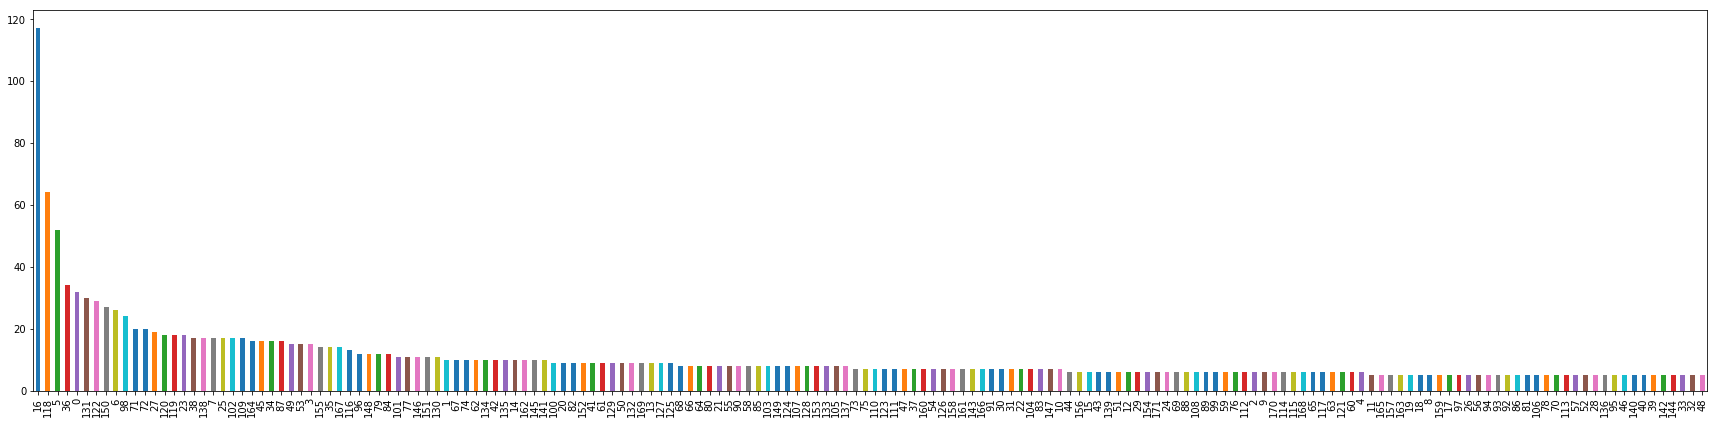

In [111]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")
print(f"clusters: {len(non_neg_cluster_df[cluster_by].unique())}")

non_neg_cluster_df[cluster_by].value_counts().plot( figsize=(30, 7), kind='bar') #.hist(figsize=(30, 7), bins=len(set(non_neg_cluster_df[cluster_by])))

In [112]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")

clean_weighted_10_outp = widgets.Output(layout={'r': '1px solid black'})
caption = widgets.Label(value='Choose parameters:')
_=widgets.interact(display_article_content, index=clean_weighted_10_drop_downs[0], 
                   change_html_series= widgets.fixed(clean_weighted_10_repers),
                   edited_tokens_freq_per_group= widgets.fixed(clean_weighted_10_gap_freq), 
                   left_context_freq_per_group= widgets.fixed(clean_weighted_10_left_context_freq), 
                   right_context_freq_per_group= widgets.fixed(clean_weighted_10_right_context_freq), 
                   change_grouped_by_tokens= widgets.fixed(clean_weighted_10_grouped), out= widgets.fixed(clean_weighted_10_outp))
#clean_weighted_10_outp

outliers: 3097 out of 4900


interactive(children=(Dropdown(description='index', options=((0, 16), (1, 118), (2, 5), (3, 36), (4, 0), (5, 1…

In [65]:
clean_weighted_10_outp

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "'Word length distribution plot for clu…

### clean_not_weighted_10


* eps=0.5, min_samples=5// 32 samples detected few neighbourhood with special character do not get clustered.
* eps=1, min_samples=5 
* eps=1.25, min_samples=5 // 56 clusters seems to detect better clusters then uncleaned ones. Seems vectors are better divided so for higher values of epsilon also gives better clusters

* eps=.75, min_samples=5// 39 samples all were having similar relative position but quite smaller than uncleaned ones, proving the point the neighbourhood is quite seperated in vector space.
* eps=0.01, min_samples=10 // 5 clusters of exactly similar neighbourhood and relative position


In [ ]:
%%time 
clusters = DBSCAN(**dbscan_params[0]).fit(clean_not_weighted_10)

cluster_by = "clean_not_weighted_10"
change_object_dataframe[cluster_by] = pd.Series(clusters.labels_, index= change_object_dataframe.index)

non_zero_cluster_mask = (change_object_dataframe[cluster_by] != -1)
non_neg_cluster_df = change_object_dataframe.loc[non_zero_cluster_mask, :]

rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate = rank_clusters(non_neg_cluster_df, cluster_by)
clean_not_weighted_10_drop_downs = [list(zip(np.arange(rank_by_size.size), rank_by_size.index)), 
                list(zip(np.arange(rank_by_uniq_editor.size), rank_by_uniq_editor.index)),
                list(zip(np.arange(rank_by_period.size), rank_by_period.index)),
                list(zip(np.arange(rank_by_rate.size), rank_by_rate.index))]

clean_not_weighted_10_freq, clean_not_weighted_10_left_context_freq, clean_not_weighted_10_right_context_freq = get_cluster_wordfreq(
    non_neg_cluster_df, cluster_by, filtered_vocabs_set)

clean_not_weighted_10_grouped = non_neg_cluster_df.reset_index().groupby(cluster_by)

# uncomment to see cluster string after cleaning
# clean_not_weighted_4_repers = create_cluster_html_cleaned(non_neg_cluster_df, cluster_by)
clean_not_weighted_10_repers = create_cluster_html(non_neg_cluster_df, cluster_by)

In [ ]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")
print(f"clusters: {len(non_neg_cluster_df[cluster_by].unique())}")

non_neg_cluster_df[cluster_by].value_counts().plot( figsize=(30, 7), kind='bar') #.hist(figsize=(30, 7), bins=len(set(non_neg_cluster_df[cluster_by])))

In [ ]:
clean_not_weighted_10_outp = widgets.Output(layout={'r': '1px solid black'})
caption = widgets.Label(value='Choose parameters:')
_=widgets.interact(display_article_content, index=clean_not_weighted_10_drop_downs[0], 
                   change_html_series= widgets.fixed(clean_not_weighted_10_repers),
                   edited_tokens_freq_per_group= widgets.fixed(clean_not_weighted_10_freq), 
                   left_context_freq_per_group= widgets.fixed(clean_not_weighted_10_left_context_freq), 
                   right_context_freq_per_group= widgets.fixed(clean_not_weighted_10_right_context_freq), 
                   change_grouped_by_tokens= widgets.fixed(clean_not_weighted_10_grouped), out= widgets.fixed(clean_not_weighted_10_outp))
#clean_not_weighted_10_outp

### notclean_weighted_10

* eps=0.5, min_samples=5// 28 samples detected few neighbourhood with special character do not get clustered.
* eps=1, min_samples=5 //72 quite a bit of noise
* eps=1.25, min_samples=5 // 56

* eps=.75, min_samples=5// 45 clusters
* eps=.1, min_samples=6 // 16 clusters of exactly similar neighbourhood and relative position/

In [ ]:
%%time 
clusters = DBSCAN(**dbscan_params[0]).fit(notclean_weighted_10)

cluster_by = "notclean_weighted_10"
change_object_dataframe[cluster_by] = pd.Series(clusters.labels_, index= change_object_dataframe.index)


non_zero_cluster_mask = (change_object_dataframe[cluster_by] != -1)
non_neg_cluster_df = change_object_dataframe.loc[non_zero_cluster_mask, :]

rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate = rank_clusters(non_neg_cluster_df, cluster_by)
notclean_weighted_10_drop_downs = [list(zip(np.arange(rank_by_size.size), rank_by_size.index)), 
                list(zip(np.arange(rank_by_uniq_editor.size), rank_by_uniq_editor.index)),
                list(zip(np.arange(rank_by_period.size), rank_by_period.index)),
                list(zip(np.arange(rank_by_rate.size), rank_by_rate.index))]

notclean_weighted_10_freq, notclean_weighted_10_left_context_freq, notclean_weighted_10_right_context_freq = get_cluster_wordfreq(
    non_neg_cluster_df, cluster_by, vocabs_set)

notclean_weighted_10_grouped = non_neg_cluster_df.reset_index().groupby(cluster_by)

# uncomment to see cluster string after cleaning
# clean_not_weighted_4_repers = create_cluster_html_cleaned(non_neg_cluster_df, cluster_by)
notclean_weighted_10_repers = create_cluster_html(non_neg_cluster_df, cluster_by)

In [ ]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")
print(f"clusters: {len(non_neg_cluster_df[cluster_by].unique())}")

non_neg_cluster_df[cluster_by].value_counts().plot( figsize=(30, 7), kind='bar') #.hist(figsize=(30, 7), bins=len(set(non_neg_cluster_df[cluster_by])))

In [ ]:
notclean_weighted_10_outp = widgets.Output(layout={'r': '1px solid black'})
caption = widgets.Label(value='Choose parameters:')
_=widgets.interact(display_article_content, index=notclean_weighted_10_drop_downs[0], 
                   change_html_series= widgets.fixed(notclean_weighted_10_repers),
                   edited_tokens_freq_per_group= widgets.fixed(notclean_weighted_10_freq), 
                   left_context_freq_per_group= widgets.fixed(notclean_weighted_10_left_context_freq), 
                   right_context_freq_per_group= widgets.fixed(notclean_weighted_10_right_context_freq), 
                   change_grouped_by_tokens= widgets.fixed(notclean_weighted_10_grouped), out= widgets.fixed(notclean_weighted_10_outp))
#notclean_weighted_10_outp

### notclean_not_weighted_10


* eps=0.5, min_samples=5// 28 samples stable neighbourhood
* eps=1, min_samples=5 // 97 clusters as eps is high more noise
* eps=.75, min_samples=5// 53 samples all were having similar relative position
* eps=0.01, min_samples=10 // 5 clusters of exactly similar neighbourhood and relative position

In [ ]:
%%time 
clusters = DBSCAN(**dbscan_params[0]).fit(notclean_not_weighted_10)

cluster_by = "notclean_not_weighted_10"
change_object_dataframe[cluster_by] = pd.Series(clusters.labels_, index= change_object_dataframe.index)


non_zero_cluster_mask = (change_object_dataframe[cluster_by] != -1)
non_neg_cluster_df = change_object_dataframe.loc[non_zero_cluster_mask, :]

rank_by_size, rank_by_uniq_editor, rank_by_period, rank_by_rate = rank_clusters(non_neg_cluster_df, cluster_by)
not_clean_not_weighted_10_drop_downs = [list(zip(np.arange(rank_by_size.size), rank_by_size.index)), 
                list(zip(np.arange(rank_by_uniq_editor.size), rank_by_uniq_editor.index)),
                list(zip(np.arange(rank_by_period.size), rank_by_period.index)),
                list(zip(np.arange(rank_by_rate.size), rank_by_rate.index))]

not_clean_not_weighted_10_freq, not_clean_not_weighted_10_left_context_freq, not_clean_not_weighted_10_right_context_freq = get_cluster_wordfreq(
    non_neg_cluster_df, cluster_by, vocabs_set)

not_clean_not_weighted_10_grouped = non_neg_cluster_df.reset_index().groupby(cluster_by)

# uncomment to see cluster string without cleaning and coment line after that
# clean_not_weighted_4_repers = create_cluster_html(non_neg_cluster_df, cluster_by)
not_clean_not_weighted_10_repers = create_cluster_html(non_neg_cluster_df, cluster_by)

In [ ]:
print(f"outliers: {sum(~non_zero_cluster_mask)} out of {len(change_object_dataframe)}")
print(f"clusters: {len(non_neg_cluster_df[cluster_by].unique())}")

non_neg_cluster_df[cluster_by].value_counts().plot( figsize=(30, 7), kind='bar') #.hist(figsize=(30, 7), bins=len(set(non_neg_cluster_df[cluster_by])))

In [ ]:
not_clean_not_weighted_10_outp = widgets.Output(layout={'r': '1px solid black'})
caption = widgets.Label(value='Choose parameters:')
_=widgets.interact(display_article_content, index=not_clean_not_weighted_10_drop_downs[0], 
                   change_html_series= widgets.fixed(not_clean_not_weighted_10_repers),
                   edited_tokens_freq_per_group= widgets.fixed(not_clean_not_weighted_10_freq), 
                   left_context_freq_per_group= widgets.fixed(not_clean_not_weighted_10_left_context_freq), 
                   right_context_freq_per_group= widgets.fixed(not_clean_not_weighted_10_right_context_freq), 
                   change_grouped_by_tokens= widgets.fixed(not_clean_not_weighted_10_grouped), out= widgets.fixed(not_clean_not_weighted_10_outp))
#not_clean_not_weighted_10_outp

In [ ]:
change_object_dataframe[change_object_dataframe.columns[-8:]].head(2)

In [ ]:
# cluster_dir = "../data/clusters/"

# file_name = article_name + "_dbscan_cluster.h5"
# full_file_path = os.path.join(cluster_dir, file_name)
# with pd.HDFStore(full_file_path, 'w') as store:
#     store.put("cluster", change_object_dataframe[change_object_dataframe.columns[-8:]], table=False)